# HW2: Plotting & viz

due Tuesday Feb 8, 2021 @ 8pm

**submission instructions:**
make a new directory in your HW github repo
(e.g., `<yourname>_hw_2/`)

## Critique the most important figure from a seminal paper in your field
a) Embed (using `<img src= ...`) the original figure/caption along with a link to the original work. 

[Buzsáki, György, Costas A. Anastassiou, and Christof Koch. "The origin of extracellular fields and currents—EEG, ECoG, LFP and spikes." Nature reviews neuroscience 13.6 (2012): 407-420.](https://www.nature.com/articles/nrn3241)

Figure 2
<img src="https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fnrn3241/MediaObjects/41583_2012_Article_BFnrn3241_Fig2_HTML.jpg?as=webp">

[Legend for Figure 2](https://www.nature.com/articles/nrn3241/figures/2)

b) In your own words, what story is this figure trying to convey? What does it do well? What could have been done better? What elements didn't need to be present to still convey the same story?

**Panels a-c are references for d, which is the most important panel.**

Neurons send information by producing a lareg synchronized change in their membrane potential. While these spikes are most strongly transmitted to connected cells, the deflections can also be observed in extracellular space. For decades, this signal has been recorded both in aggregate (e.g., EEG, LFP) and at the single neuron level, under the assumption that they have the same sources. Buzsaki et al (2012) experimentally and computationally demonstrated this relationship.

Panel 2d, which shows just one small piece of this model, is one of my favorite figures. The authors built a detailed computational model of a neuron and simulated a spike dissipating through extracellular space. The grid of waveforms shows the observed shape of the spike at each location in relation to the neuron (black); the color indicates the amplitude of the spike. This figure illustrates that a spike generated by one neuron will not just decrease in size, but also have a dramatically different shape depending on proximity to different parts of the cell (top = dendrites, middle = soma, bottom = axon). Extracellular recordings usually allow us to eavesdrop from just one or small number of locations, and are blind to the shape and position of the neurons. This simulation and visualization really helped me understand the larger context behind the singals I was collecting and analyzing.

The panel integrates a huge amount of information that would take the reader much longer to understand if it had been split into multiple pieces, and it does so in an intuitive way that doesn't require digging through a million legends and labels. Panels a-c are more opaque and not necessary to understand panel d on its own, but I appreciate that all of these details were important for their full paper.

## Reproduce one of your old published-paper quality plots with Bokeh or matplotlib.

a) Provide the original plot, the recreated Bokeh/matlibplot plot, and the Python code used to make the new plot.  You can ask us for an example from us if you don't have your own plots.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as image
import seaborn as sns

[]

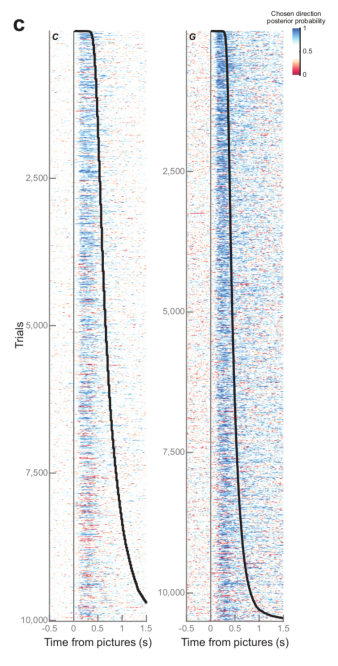

In [2]:
# load original png
original = image.imread('data/dirdec_postprob_figure.png')

# show figure
fig = plt.figure(figsize=(8, 12))
ax = fig.add_subplot()

ax.imshow(original)
ax.axis('off')
plt.setp(ax, xticks=[], yticks=[])

Over thousands of trials, two non-human primates (subject C: left panel & subjct G: right panel) selected between pairs of pictures that represented different juice rewards. We trained a linear decoder to predict the animals' choice behavior (left vs. right picture) from firing rates of striatal (caudate nucelus) neurons. 

Here, we show the posterior probability calculated on independent trials in sliding 20 ms windows over the course of the trial; blue = correct (i.e. matching animals' choice), red = incorrect. Trials are ordered from fastest to slowest response time (black curve).

The strongest choice direction prediction occurs immediately after the presentation of pictures, independent of response time, suggesting this population response is reflecting rapid value processing early in the trial rather than motor (or cognitive) processing leading up the final decision.


In [3]:
# load my data
postprob = pd.read_csv('data/large_files/dirdec_postprob_minidata.csv') # data
timelabel = pd.read_csv('data/large_files/dirdec_postprob_tmids.csv') # ms time of samples

In [4]:
# look up time idx references

# pictures onset, t=0
t_0 = (timelabel.t_mids - 0).abs().argmin()

# ms between consecutive samples
t_step = timelabel.t_mids[0:2].diff()[1]

# pull samples corresponding to nice ticks
t_ticks = np.arange(-0.5, 2, 0.5)
t_idx = np.empty(t_ticks.shape)
for i in range(len(t_ticks)):
    t_idx[i] = (timelabel.t_mids - t_ticks[i]*1000).abs().argmin()

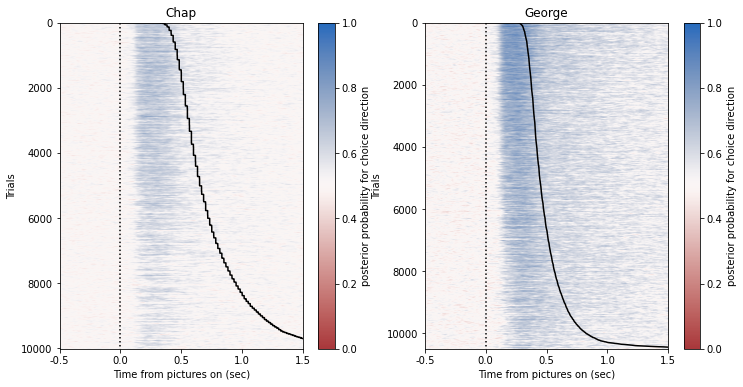

In [5]:
# make figure with trials split by subject & ordered by response time

fig = plt.figure(figsize=(12,6))

subjects = ['Chap','George']

for s in range(len(subjects)):
    
    # make new subplot for subject
    ax = fig.add_subplot(1, len(subjects), s+1)
    
    # pull trials for this subject
    subj_idx = postprob.subject==subjects[s]
    num_trials = sum(subj_idx)
    
    # restrict data to this subject
    subj_postprob = np.array(postprob[subj_idx].iloc[:,2:])
    subj_rt = np.array(t_0 + postprob.rt[subj_idx] / t_step) # convert ms to time sample bin for vis
    
    # reorder trials by response time
    trial_order = subj_rt.argsort()
    
    # plot heatmap of data
    hm = ax.imshow(subj_postprob[trial_order,:],
                  vmin=0, vmax=1, 
                  cmap=sns.color_palette('vlag_r', as_cmap=True)) #sns.diverging_palette(20, 220, as_cmap=True))
    
    # add response time curve
    ax.plot(subj_rt[trial_order], range(num_trials), c='k')
    
    # add reference line for pictures presentation (t=0)
    ax.plot([t_0, t_0], [0, num_trials-1], c='k', linestyle=':')
    
    # let axis take up whole space
    ax.set_aspect('auto')
    
    # format
    plt.setp(ax, title=subjects[s], 
             xlabel='Time from pictures on (sec)', 
             xlim=(t_idx[0], t_idx[-1]), xticks=t_idx, xticklabels=t_ticks,
             ylabel='Trials')

    plt.colorbar(hm, label='posterior probability for choice direction') # not sure if using 'plt' here is correct...


#TODO: should improve colormap to be nicer match for original figure...

b) Add some (new) dynamic interactions to the plot--does it help tell your story better?

##  Volcano-induced Blastwave moving through California in 2022

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f9/Shockwave_from_Hunga_Tonga_GOES_17.gif/440px-Shockwave_from_Hunga_Tonga_GOES_17.gif" width="30%">

The massive volcanic eruption near Tonga in the Pacific Ocean (20.550°S 175.385°W) occurred at 04:14:45 [UTC](https://en.wikipedia.org/wiki/Coordinated_Universal_Time) on 15 January 2022. The above animation (credit: Tim Schmit, NOAA/NESDIS/ASPB) shows propogation of the shockwave across the Earth as seen from space (using infrared measurements of water vapor). That shockwave was also measured as changing pressure in weather stations around the world. 

a) The CSV file `data/california_pressure_2022_01_15.csv` contains [Automated Surface Observing System (ASOS)](https://mesonet.agron.iastate.edu/ASOS/) pressure measurements at 64 stations in California taken several hours later that day, observed with 1-minute resolution. Read this data into a `pandas` DataFrame and then plot in the same figure the pressure as a function of time at SBA (Santa Barbara Municipal Airport, in Southern California), OAK (Oakland Airport, Bay Area), and MHS (Mount Shasta City, in Northern California). To allow a better visual comparison between the three, divide each plot by the initial value at the start of each of the timeseries. Overplot a 5-min thick vertical line for each timeseries (with the same color as the line) at the maximum of that series.

In [6]:
import pandas as pd
import numpy as np

from datetime import datetime
import dateutil.parser as parser

#!pip install geopandas
import geopandas

#!pip install haversine
from haversine import haversine

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns


%matplotlib inline

In [7]:
# load data
df_pressure = pd.read_csv('data/california_pressure_2022_01_15.csv')

In [8]:
# reduce dataframe to useful stations
stations_mini = ['SBA','OAK','MHS']
df_mini = df_pressure[stations_mini]

In [9]:
# transform pressure measurements as proportion of initial value
initial_values = df_mini.iloc[0,:]
df_mini_prop = df_mini/initial_values

In [10]:
# find peak pressure in each timeseries (restrcting to first 300 min to find initial peak)
peak_idx = df_mini_prop.iloc[:300,:].idxmax()

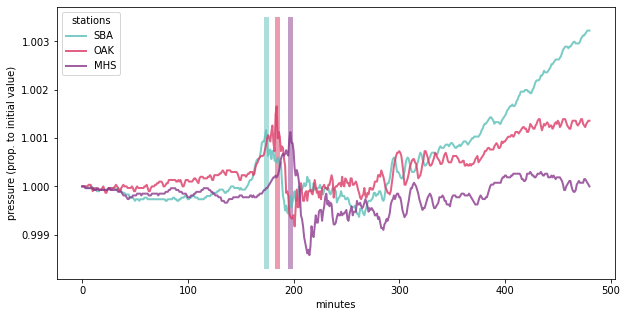

In [11]:
# generate figure (try to use nicer matplotlib practices...)

# make figure, edit ax
f, ax = plt.subplots()
f.set_size_inches(10,5)

# plot pressure lines
lines_pressure = ax.plot(df_mini_prop, zorder=1)

# plot peaks
Y = ax.get_ylim() # use Y dim to fill plot
lines_peaks = ax.plot(np.tile(peak_idx,(2,1)),
                     np.tile(Y,(3,1)).transpose(),
                     zorder=0)
# adjust colors, etc.
colors = ['#5ABFB8','#DC3965','#89388C']
for i in range(len(lines_pressure)):
    plt.setp(lines_pressure[i], color=colors[i], linewidth=2, alpha=0.8)
    plt.setp(lines_peaks[i], color=colors[i], linewidth=5, alpha=0.5)

# add labels
# ax.set_xlabel('minutes')
plt.setp(ax, xlabel='minutes', ylabel='pressure (prop. to initial value)')
ax.legend(stations_mini, title='stations')

b) What can you say about the similarity or dissimilarity of the three series? Why argument can you make that the similarities are due to the Tongan shockwave and not other effects? What do you notice about the location of the maximum of the three series?

**The pressure measured at these three stations is qualitatively fairly similar: a fairly stable initial period is disrupted by a rapid increase and sharp decrease, followed by a wobbly return to baseline (MHS) or continued increase (SBA and OAK).**

**The sharp deflections have a similar shape and occur close together in time, with small offsets consistent with an event traveling north (SBA -> OAK -> MHS).**

**The largest increase occurs at OAK. This station has the highest baseline pressure, possibly because it is close to a fault line. (Sorry for the guesses, I haven't learned about earth science since high school...)**

c) On a map of California, create a static vizualization of the timelag of the passage of the shockwave through the 64 stations in California. You might find it helpful to detect significant changes at each station using rolling percent changes on ~5-10 minute intervals (cf. [`.pct_change(periods=...)`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pct_change.html) in pandas). The file `data/ca_asos.csv` contains the latitude and longitude of the stations. 

In [12]:
# get 64 CA stations from timeseries data
stations_CA = df_pressure.columns[1:]

[Text(0.5, 0, 'minutes'), Text(0, 0.5, 'presure % change')]

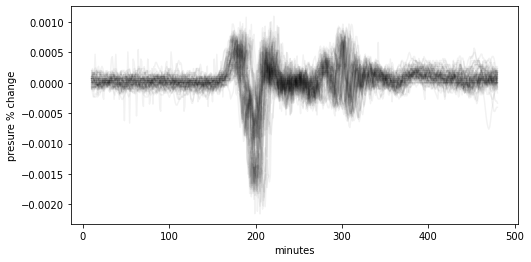

In [13]:
# get index of max timelag, from %change in pressure
pressure_change = df_pressure.iloc[:, 1:].pct_change(periods=10)

# check out what pressure change looks like
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot()
ax.plot(pressure_change, c=[0, 0, 0], alpha=0.05)
plt.setp(ax, xlabel='minutes', ylabel='presure % change')


I see 2 ways to find the max pressure change:

-- option 1 = easy: find index of large negative deflection @ ~200 min\
-- option 2 = a little more complicated: find the index of the first max pressure change (restrict search to time before negative deflection from option 1)

Option 2 makes a slightly nicer gradient across all CA stations, so I'm guessing this is a more accurate metric of shockwave times. Using this for the rest of the assignment.

In [14]:
## find point of max pressure change: try 2 options

# ## option 1: large negative deflection ~200 min
# peak_idx = pressure_change.idxmin()


## option2: max positive pressure change before negative deflection
cutoff = pressure_change.idxmin()

# search for max before cutoff
peak_idx = np.empty(len(stations_CA), dtype='int')
for i in range(len(stations_CA)):
    pressure_change_short = pressure_change.iloc[:cutoff[i], i]
    peak_idx[i] = pressure_change_short.idxmax()


[130.0, 260.0, Text(0.5, 0, 'minutes'), Text(0, 0.5, 'pressure % change')]

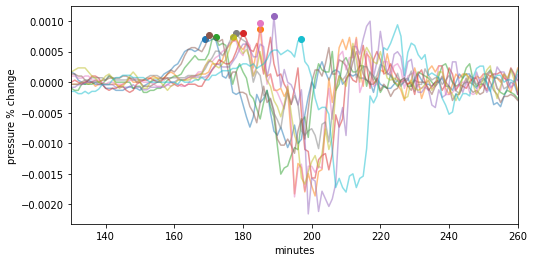

In [15]:
# sanity check 10 random stations to make sure this worked...
N = 10

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot()

sns.set_palette("bright", N)
for i in np.random.choice(len(stations_CA), size=N, replace=False):
    ax.plot(pressure_change.iloc[:,i], alpha=.5)
    ax.scatter(peak_idx[i], pressure_change.iloc[peak_idx[i],i])

# zoom in to investigate
plt.setp(ax, xlim=(130, 260), xlabel='minutes', ylabel='pressure % change')

In [16]:
# make this into a pd dataframe for easy merging later
peakchange = pd.DataFrame({'stid': stations_CA, 
                           'wave_peak': peak_idx})

In [17]:
# load station location data
df_stations = pd.read_csv('data/ca_asos.csv')


In [18]:
# reduce location data to 64 CA stations from timeseries data
df_stations_CA = df_stations[df_stations['stid'].isin(stations_CA)]


In [19]:
# merge station info with max timelag data
df_merged_CA = pd.merge(peakchange, df_stations_CA, on='stid')

use geopandas to add overlay of CA map

using this as reference: https://geopandas.org/en/stable/gallery/plotting_basemap_background.html


In [20]:
# for now, just use USA map from preloaded datasets
maps = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
USA = maps[maps.name=='United States of America']

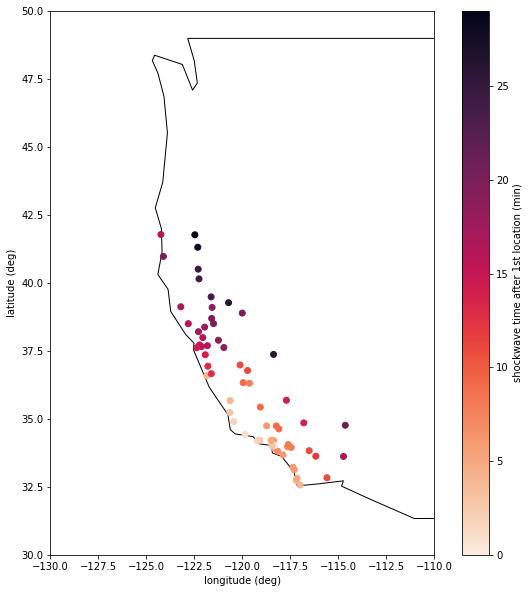

In [21]:
# generate figure with CA + all stations, using heatmap to indicate time of shockwave

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()

# show USA map
USA.plot(ax=ax, edgecolor='k', facecolor='w')

# add staions, using heatmap to indicate time of shockwave
ss = ax.scatter(df_merged_CA['lon'], df_merged_CA['lat'], 
            c=df_merged_CA.wave_peak - df_merged_CA.wave_peak.min(),
            cmap=sns.color_palette('rocket_r', as_cmap=True), 
            alpha=1)

# format
plt.setp(ax, xlim=(-130, -110), ylim=(30, 50), xlabel='longitude (deg)', ylabel='latitude (deg)')
fig.colorbar(ss, label='shockwave time after 1st location (min)') # not sure if using 'fig' here is correct...


d) Pick one station and determine when you believe the shockwave first passed through that station. Using this information and the time of the explosion determine the speed of the shockwave. How does this compare to the speed of sound in air?

In [22]:
# use station with earliest shockwave as example
ex_station = peak_idx.argmax()

In [23]:
# time & location of explosion
explosion_time = '2022-01-15 04:14:45'
t0 = parser.parse(explosion_time)

explosion_coords = (175.385, 20.550) # deg W (lat), deg S (long)

In [24]:
# time & location of shockwave through example station
ex_station_time = df_pressure['valid(UTC)'][ex_station]
t1 = parser.parse(ex_station_time)

ex_station_info = df_stations.iloc[ex_station]
ex_station_coords = tuple(ex_station_info[['lat','lon']])

In [25]:
# calculate time difference
t_diff = (t1-t0).seconds;

calculate position difference using haversine so I don't have to redo lots of 3D geometry...

using this as reference: https://towardsdatascience.com/calculating-distance-between-two-geolocations-in-python-26ad3afe287b


In [26]:
# get speed of shockwave
speed_land = round(haversine(explosion_coords, ex_station_coords),1)
print(f"Speed of shockwave: {speed_land} m/s")

Speed of shockwave: 5420.1 m/s


In [27]:
# get speed of sound in air
from scipy import constants as cons

speed_air = cons.speed_of_sound
print(f"Speed of sound in air: {speed_air} m/s")

Speed of sound in air: 340.5 m/s


**The sound of the explosion travels ~16x faster than the shockwave.**

**EXTRA CREDIT**  Produce an animation of passage of the shockwave through California using this dataset. Hint: take at look at `matplotlib.animation.FuncAnimation`.